## Okra Disease Classification

In [ ]:
!pip install fastai albumentations torchvision

In [2]:
import sys
import torch
print(f"Python version: {sys.version}, {sys.version_info} ")
print(f"Pytorch version: {torch.__version__} ")

Python version: 3.7.13 (default, Mar 29 2022, 02:18:16) 
[GCC 7.5.0], sys.version_info(major=3, minor=7, micro=13, releaselevel='final', serial=0) 
Pytorch version: 1.13.0a0+gitd566718 


In [3]:
import fastai
fastai.__version__

'2.7.10'

In [4]:
!rocm-smi



======================= ROCm System Management Interface =======================
================================= Concise Info =================================
GPU  Temp   AvgPwr  SCLK     MCLK   Fan  Perf  PwrCap  VRAM%  GPU%  
0    38.0c  4.0W    2760Mhz  96Mhz  0%   auto  143.0W   19%   0%    
============================= End of ROCm SMI Log ==============================


In [ ]:
from fastai.vision.all import *
from fastai.vision import models
from torchvision import transforms
from pathlib import Path

set_seed(5)

In [6]:
batch_size = 64

location = "./Okra_Dataset"
path = Path(location)

## Image Augmentation

- Random Cropping
- Horizontal Flipping
- Vertical Flipping
- Modifying Brightness/Contrast
- Rotation

In [7]:
import albumentations

class AlbumentationsTransform(DisplayedTransform):
    split_idx,order=0,2
    def __init__(self, train_aug): store_attr()
    
    def encodes(self, img: PILImage):
        aug_img = self.train_aug(image=np.array(img))['image']
        return PILImage.create(aug_img)

# Image Augmentations
def get_train_augmentation(): return albumentations.Compose([
            albumentations.RandomCrop(224,224),
            albumentations.HorizontalFlip(p=0.25),
            albumentations.VerticalFlip(p=0.25),
            albumentations.RandomBrightnessContrast(brightness_limit=0.5, contrast_limit=0.3, p=0.25),
            albumentations.SafeRotate(limit=90, p=0.25),
])

## Dataset
- Image Resolution: 224 x 224 px
- Two classses: Diseased Okra, Healthy Okra
- Total Images: 1949
- Training Images: 1587 (~80%)
- Testing Images: 274 (~15%)
- Validation Images: 88 (~5%)

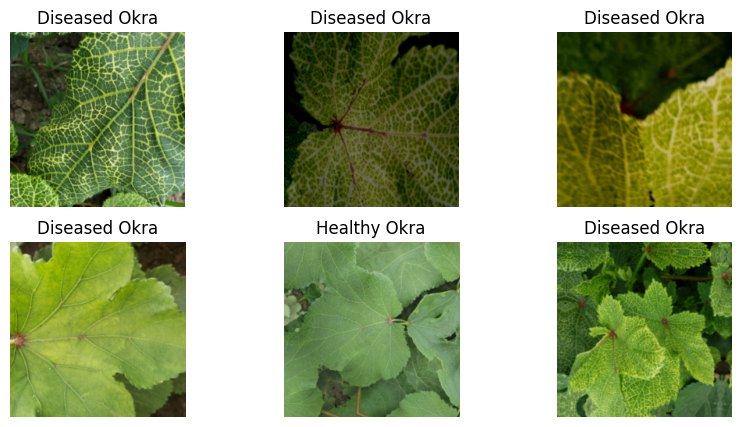

In [8]:
dls = ImageDataLoaders.from_folder(
    path, pat=r'(.+)_\d+.jpg$',
    item_tfms=
    [
        Resize((224, 224), method='squish'),
        AlbumentationsTransform(get_train_augmentation()) 
    ], bs=batch_size)

dls.train.show_batch(max_n=6, figsize=(10,5))

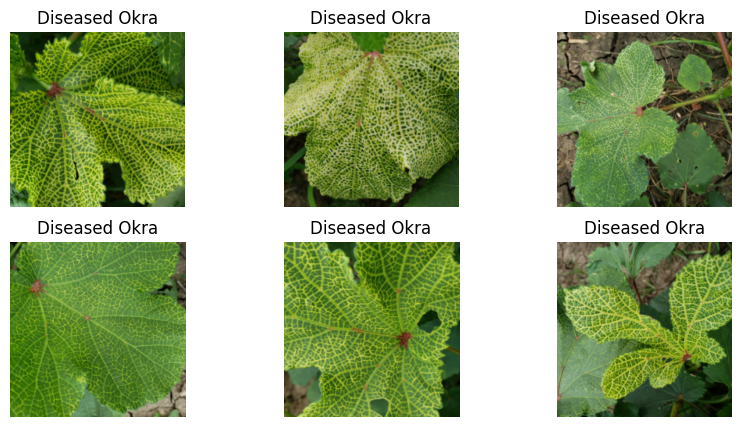

In [9]:
dls.valid.show_batch(max_n=6, figsize=(10,5))

In [10]:
print("Class Labels: ", dls.vocab)

Class Labels:  ['Diseased Okra', 'Healthy Okra']


## Model
- Model Name: ResNet18,
- Transfer Learning: Pretrained ImageNet Weights,
- Loss Function: CrossEntropyFlat,
- Optimizer: Adam, 
- Learning Rate: 0.01, 
- Momentum=0.1

In [11]:
learn = vision_learner(dls, 
    resnet18, pretrained=True, metrics=[accuracy, error_rate])

/opt/conda/lib/python3.7/site-packages/torchvision-0.14.0a0+369317f-py3.7-linux-x86_64.egg/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/opt/conda/lib/python3.7/site-packages/torchvision-0.14.0a0+369317f-py3.7-linux-x86_64.egg/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

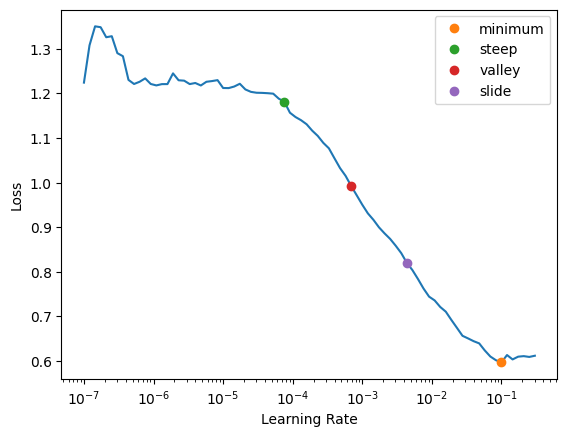

In [16]:
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

In [17]:
lrs

SuggestedLRs(minimum=0.010000000149011612, steep=7.585775892948732e-05, valley=0.0006918309954926372, slide=0.004365158267319202)

In [14]:
learn.fit_one_cycle(10, 0.01)
learn.save('resnet18-okra')

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.783013,0.114188,0.963504,0.036496,00:53
1,0.438065,0.017052,0.996350,0.003650,00:34
2,0.285357,0.011325,0.996350,0.003650,00:33
3,0.201245,0.006734,1.000000,0.000000,00:34
4,0.148315,0.002908,1.000000,0.000000,00:35
5,0.125192,0.001823,1.000000,0.000000,00:35
6,0.097937,0.001215,1.000000,0.000000,00:34
7,0.076594,0.001476,1.000000,0.000000,00:34
8,0.067586,0.001720,1.000000,0.000000,00:34
9,0.063124,0.001805,1.000000,0.000000,00:33


Path('Okra_Dataset/models/resnet18-okra.pth')

In [15]:
learn.export('resnet18-okra.pkl')

### Training Confusion Matrix

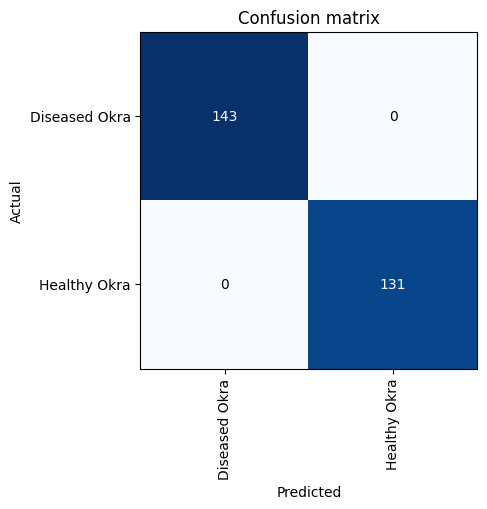

In [20]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(5,5), dpi=100)

In [21]:
import pathlib
import glob
import os
test_location = './Okra_Dataset/test/'

cnt = 0
actual_label = []
output_label = []

# Inference block
print('False Positives')
for i in glob.glob(os.path.join(test_location, '*/*')):
    #Image prediction
    result = learn.predict(Path(i))
    actual_label.append(os.path.basename(os.path.dirname(i)))
    output_label.append(result[0])
    if result[0] == os.path.basename(os.path.dirname(i)):
        cnt = cnt + 1
    else:
        print('Actual {0} Predict {1} Fname: {2}'.format(os.path.basename(os.path.dirname(i)), result[0], os.path.basename(i)))
        print('************************************************************')
    
# Calculating the accuracy
print('Total images: {0}, TP+TN: {1}'.format(len(actual_label), cnt))
print('Final Accurarcy: {0}'.format(100*(cnt / len(actual_label))))

False Positives


Actual Healthy Okra Predict Diseased Okra Fname: 20210608_171527.jpg
************************************************************


Total images: 88, TP: 87
Final Accurarcy: 98.86363636363636


In [22]:
def plot_confusion_matrix(cm, vocab, normalize=False, title='Confusion matrix', cmap="Blues", norm_dec=2,
                              plot_txt=True, **kwargs):
        "Plot the confusion matrix, with `title` and using `cmap`."
        # This function is mainly copied from the sklearn docs
        if normalize: cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fig = plt.figure(**kwargs)
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        tick_marks = np.arange(len(vocab))
        plt.xticks(tick_marks, vocab, rotation=90)
        plt.yticks(tick_marks, vocab, rotation=0)
        
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            print("Normalized confusion matrix")
        else:
            print('Confusion matrix, without normalization')

        print(cm)

        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, cm[i, j],
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.show()
        
vocab = list(set(actual_label))

In [24]:
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report

mat_result = confusion_matrix(actual_label, output_label)
print('Confusion Matrix :')

print(mat_result) 
print('Accuracy Score :',accuracy_score(actual_label, output_label)) 
print('Report : ')
print(classification_report(actual_label, output_label))

Confusion Matrix :
[[44  0]
 [ 1 43]]
Accuracy Score : 0.9886363636363636
Report : 
               precision    recall  f1-score   support

Diseased Okra       0.98      1.00      0.99        44
 Healthy Okra       1.00      0.98      0.99        44

    micro avg       0.99      0.99      0.99        88
    macro avg       0.99      0.99      0.99        88
 weighted avg       0.99      0.99      0.99        88



### Validation Confusion Matrix

Confusion matrix, without normalization
[[44  0]
 [ 1 43]]


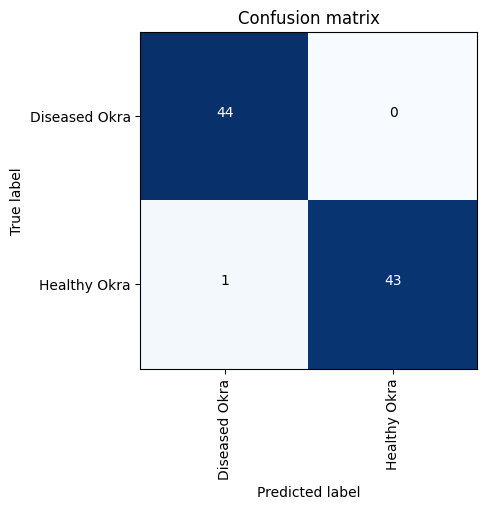

In [26]:
plot_confusion_matrix(mat_result, vocab, figsize=(5,5), dpi=100)